In [4]:
"""
Grid based sweep planner
author: Atsushi Sakai
"""

import math
from enum import IntEnum
import numpy as np
import matplotlib.pyplot as plt
import sys
import pathlib
from IPython.display import clear_output
from angle import rot_mat_2d
from grid_map_lib.grid_map_lib import GridMap

do_animation = True


class SweepSearcher:
    class SweepDirection(IntEnum):
        UP = 1
        DOWN = -1

    class MovingDirection(IntEnum):
        RIGHT = 1
        LEFT = -1

    def __init__(self,
                 moving_direction, sweep_direction, x_inds_goal_y, goal_y):
        self.moving_direction = moving_direction
        self.sweep_direction = sweep_direction
        self.turing_window = []
        self.update_turning_window()
        self.x_indexes_goal_y = x_inds_goal_y
        self.goal_y = goal_y

    def move_target_grid(self, c_x_index, c_y_index, grid_map):
        n_x_index = self.moving_direction + c_x_index
        n_y_index = c_y_index

        # found safe grid
        if not grid_map.check_occupied_from_xy_index(n_x_index, n_y_index,
                                                     occupied_val=0.5):
            return n_x_index, n_y_index
        else:  # occupied
            next_c_x_index, next_c_y_index = self.find_safe_turning_grid(
                c_x_index, c_y_index, grid_map)
            if (next_c_x_index is None) and (next_c_y_index is None):
                # moving backward
                next_c_x_index = -self.moving_direction + c_x_index
                next_c_y_index = c_y_index
                if grid_map.check_occupied_from_xy_index(next_c_x_index,
                                                         next_c_y_index):
                    # moved backward, but the grid is occupied by obstacle
                    return None, None
            else:
                # keep moving until end
                while not grid_map.check_occupied_from_xy_index(
                        next_c_x_index + self.moving_direction,
                        next_c_y_index, occupied_val=0.5):
                    next_c_x_index += self.moving_direction
                self.swap_moving_direction()
            return next_c_x_index, next_c_y_index

    def find_safe_turning_grid(self, c_x_index, c_y_index, grid_map):

        for (d_x_ind, d_y_ind) in self.turing_window:

            next_x_ind = d_x_ind + c_x_index
            next_y_ind = d_y_ind + c_y_index

            # found safe grid
            if not grid_map.check_occupied_from_xy_index(next_x_ind,
                                                         next_y_ind,
                                                         occupied_val=0.5):
                return next_x_ind, next_y_ind

        return None, None

    def is_search_done(self, grid_map):
        for ix in self.x_indexes_goal_y:
            if not grid_map.check_occupied_from_xy_index(ix, self.goal_y,
                                                         occupied_val=0.5):
                return False

        # all lower grid is occupied
        return True

    def update_turning_window(self):
        # turning window definition
        # robot can move grid based on it.
        self.turing_window = [
            (self.moving_direction, 0.0),
            (self.moving_direction, self.sweep_direction),
            (0, self.sweep_direction),
            (-self.moving_direction, self.sweep_direction),
        ]

    def swap_moving_direction(self):
        self.moving_direction *= -1
        self.update_turning_window()

    def search_start_grid(self, grid_map):
        x_inds = []
        y_ind = 0
        if self.sweep_direction == self.SweepDirection.DOWN:
            x_inds, y_ind = search_free_grid_index_at_edge_y(
                grid_map, from_upper=True)
        elif self.sweep_direction == self.SweepDirection.UP:
            x_inds, y_ind = search_free_grid_index_at_edge_y(
                grid_map, from_upper=False)

        if self.moving_direction == self.MovingDirection.RIGHT:
            return min(x_inds), y_ind
        elif self.moving_direction == self.MovingDirection.LEFT:
            return max(x_inds), y_ind

        raise ValueError("self.moving direction is invalid ")


def find_sweep_direction_and_start_position(ox, oy):
    # find sweep_direction
    max_dist = 0.0
    vec = [0.0, 0.0]
    sweep_start_pos = [0.0, 0.0]
    for i in range(len(ox) - 1):
        dx = ox[i + 1] - ox[i]
        dy = oy[i + 1] - oy[i]
        d = np.hypot(dx, dy)

        if d > max_dist:
            max_dist = d
            vec = [dx, dy]
            sweep_start_pos = [ox[i], oy[i]]

    return vec, sweep_start_pos


def convert_grid_coordinate(ox, oy, sweep_vec, sweep_start_position):
    tx = [ix - sweep_start_position[0] for ix in ox]
    ty = [iy - sweep_start_position[1] for iy in oy]
    th = math.atan2(sweep_vec[1], sweep_vec[0])
    converted_xy = np.stack([tx, ty]).T @ rot_mat_2d(th)

    return converted_xy[:, 0], converted_xy[:, 1]


def convert_global_coordinate(x, y, sweep_vec, sweep_start_position):
    th = math.atan2(sweep_vec[1], sweep_vec[0])
    converted_xy = np.stack([x, y]).T @ rot_mat_2d(-th)
    rx = [ix + sweep_start_position[0] for ix in converted_xy[:, 0]]
    ry = [iy + sweep_start_position[1] for iy in converted_xy[:, 1]]
    return rx, ry


def search_free_grid_index_at_edge_y(grid_map, from_upper=False):
    y_index = None
    x_indexes = []

    if from_upper:
        x_range = range(grid_map.height)[::-1]
        y_range = range(grid_map.width)[::-1]
    else:
        x_range = range(grid_map.height)
        y_range = range(grid_map.width)

    for iy in x_range:
        for ix in y_range:
            if not grid_map.check_occupied_from_xy_index(ix, iy):
                y_index = iy
                x_indexes.append(ix)
        if y_index:
            break

    return x_indexes, y_index


def setup_grid_map(ox, oy, resolution, sweep_direction, offset_grid=10):
    width = math.ceil((max(ox) - min(ox)) / resolution) + offset_grid
    height = math.ceil((max(oy) - min(oy)) / resolution) + offset_grid
    center_x = (np.max(ox) + np.min(ox)) / 2.0
    center_y = (np.max(oy) + np.min(oy)) / 2.0

    grid_map = GridMap(width, height, resolution, center_x, center_y)
    grid_map.print_grid_map_info()
    grid_map.set_value_from_polygon(ox, oy, 1.0, inside=False)
    grid_map.expand_grid()

    x_inds_goal_y = []
    goal_y = 0
    if sweep_direction == SweepSearcher.SweepDirection.UP:
        x_inds_goal_y, goal_y = search_free_grid_index_at_edge_y(
            grid_map, from_upper=True)
    elif sweep_direction == SweepSearcher.SweepDirection.DOWN:
        x_inds_goal_y, goal_y = search_free_grid_index_at_edge_y(
            grid_map, from_upper=False)

    return grid_map, x_inds_goal_y, goal_y


def sweep_path_search(sweep_searcher, grid_map, grid_search_animation=False):
    # search start grid
    c_x_index, c_y_index = sweep_searcher.search_start_grid(grid_map)
    if not grid_map.set_value_from_xy_index(c_x_index, c_y_index, 0.5):
        print("Cannot find start grid")
        return [], []

    x, y = grid_map.calc_grid_central_xy_position_from_xy_index(c_x_index,
                                                                c_y_index)
    px, py = [x], [y]

    fig, ax = None, None
    if grid_search_animation:
        fig, ax = plt.subplots()
        # for stopping simulation with the esc key.
        fig.canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])

    while True:
        c_x_index, c_y_index = sweep_searcher.move_target_grid(c_x_index,
                                                               c_y_index,
                                                               grid_map)

        if sweep_searcher.is_search_done(grid_map) or (
                c_x_index is None or c_y_index is None):
            print("Done")
            break

        x, y = grid_map.calc_grid_central_xy_position_from_xy_index(
            c_x_index, c_y_index)

        px.append(x)
        py.append(y)

        grid_map.set_value_from_xy_index(c_x_index, c_y_index, 0.5)

        if grid_search_animation:
            grid_map.plot_grid_map(ax=ax)
            plt.pause(1.0)

    return px, py


def planning(ox, oy, resolution,
             moving_direction=SweepSearcher.MovingDirection.RIGHT,
             sweeping_direction=SweepSearcher.SweepDirection.UP,
             ):
    sweep_vec, sweep_start_position = find_sweep_direction_and_start_position(
        ox, oy)

    rox, roy = convert_grid_coordinate(ox, oy, sweep_vec,
                                       sweep_start_position)

    grid_map, x_inds_goal_y, goal_y = setup_grid_map(rox, roy, resolution,
                                                     sweeping_direction)

    sweep_searcher = SweepSearcher(moving_direction, sweeping_direction,
                                   x_inds_goal_y, goal_y)

    px, py = sweep_path_search(sweep_searcher, grid_map)

    rx, ry = convert_global_coordinate(px, py, sweep_vec,
                                       sweep_start_position)

    print("Path length:", len(rx))

    return rx, ry


def planning_animation(ox, oy, resolution):  # pragma: no cover
    px, py = planning(ox, oy, resolution)

    # animation
    if do_animation:
        clear_output(wait=True)
        for ipx, ipy in zip(px, py):
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect(
                'key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
            plt.plot(ox, oy, "-xb")
            plt.plot(px, py, "-r")
            plt.plot(ipx, ipy, "or")
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.1)

        plt.cla()
        plt.plot(ox, oy, "-xb")
        plt.plot(px, py, "-r")
        plt.axis("equal")
        plt.grid(True)
        plt.pause(0.1)
        plt.close()


start!!
width: 30
height: 30
resolution: 0.05
center_x: 0.5
center_y: 0.5
left_lower_x: -0.25
left_lower_y: -0.25
ndata: 900
Done
Path length: 324
done!!


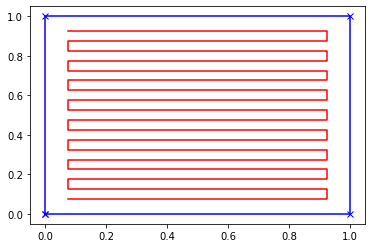

In [19]:

print("start!!")

# ox = [0.0, 2.0]
# oy = [0.0, -20.0, 0.0, 30.0, 60.0, 80.0, 0.0]
# resolution = 5.0
# planning_animation(ox, oy, resolution)

ox = [0.0, 1.0, 1.0, 0.0, 0.0]
oy = [0.0, 0.0, 1.0, 1.0, 0.0]
resolution = 0.05
px, py = planning(ox, oy, resolution)
plt.plot(ox, oy, "-xb")
plt.plot(px, py, "-r")
# planning_animation(ox, oy, resolution)

# ox = [0.0, 20.0, 50.0, 200.0, 130.0, 40.0, 0.0]
# oy = [0.0, -80.0, 0.0, 30.0, 60.0, 80.0, 0.0]
# resolution = 5.0
# planning_animation(ox, oy, resolution)

# if do_animation:
#     plt.show()
print("done!!")
